# Importing Libraries

In [541]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.regression.linear_model import yule_walker

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from scipy.stats import boxcox

from tqdm import tqdm_notebook

from itertools import product

from statistics import variance as var

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize']= (20,8)

%matplotlib inline

# Reading in our dataset

In [542]:
df = pd.read_csv('AAPL.csv')

In [543]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [544]:
df.shape

(10468, 7)

In [545]:
df = df.loc[10100:10467]
# df = df.loc[6072:10469]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
10100,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.264999,143301900
10101,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.850845,97664900
10102,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.479851,155088000
10103,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.761627,109578200
10104,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.881622,105158200


In [546]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [547]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,368.000000,368.000000,368.000000,368.000000,368.000000,3.680000e+02
mean,147.319647,149.035000,145.639076,147.387201,146.794376,9.224985e+07
std,16.841570,17.131016,16.605805,16.896536,17.091592,2.753776e+07
min,119.029999,120.400002,116.209999,116.360001,115.502800,4.100000e+07
25%,132.997494,134.132496,131.469998,132.939999,132.102112,7.288545e+07
50%,146.544998,148.019996,145.540001,146.625000,146.025620,8.864400e+07
75%,161.119995,164.110001,158.824993,161.462502,161.020462,1.067793e+08
max,182.630005,182.940002,179.119995,182.009995,181.511703,1.954327e+08


In [548]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close','Volume'], axis=1)
df.head()

,Date,Close
10100,2021-01-04,129.410004
10101,2021-01-05,131.009995
10102,2021-01-06,126.599998
10103,2021-01-07,130.919998
10104,2021-01-08,132.050003


In [549]:
date = df['Date'].to_numpy()
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [550]:
df.tail()

,Close
Date,
2022-06-13,131.880005
2022-06-14,132.759995
2022-06-15,135.429993
2022-06-16,130.059998
2022-06-17,131.559998


# Plotting Histogram

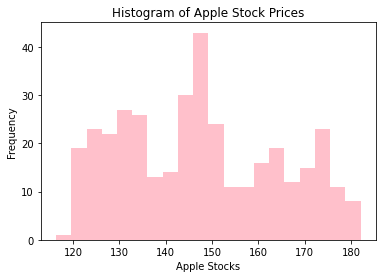

In [551]:
plt.hist(df['Close'],bins=20, color='pink')
plt.title('Histogram of Apple Stock Prices');
plt.xlabel('Apple Stocks');
plt.ylabel('Frequency');

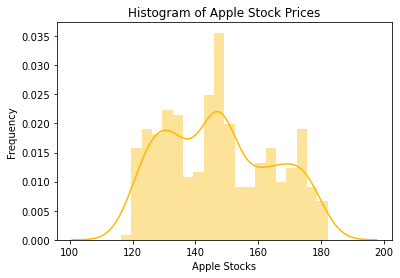

In [552]:
sns.distplot(df['Close'],bins=20, hist=True, kde=True,color='#fcba03')
plt.title('Histogram of Apple Stock Prices');
plt.xlabel('Apple Stocks');
plt.ylabel('Frequency');

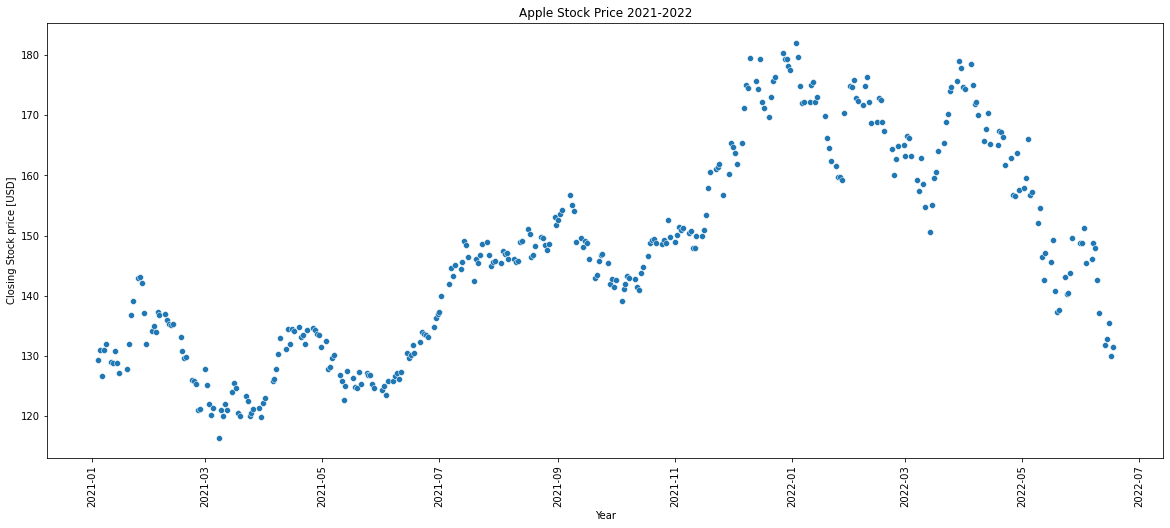

In [553]:
plt.figure(figsize=(20, 8))
sns.scatterplot(df.index, df['Close']);
plt.title('Apple Stock Price 2021-2022');
plt.ylabel('Closing Stock price [USD]');
plt.xlabel('Year');
plt.xticks(rotation=90)
# plt.savefig('Scatter_Apple_Stock_Price.png', dpi=600)
plt.show()

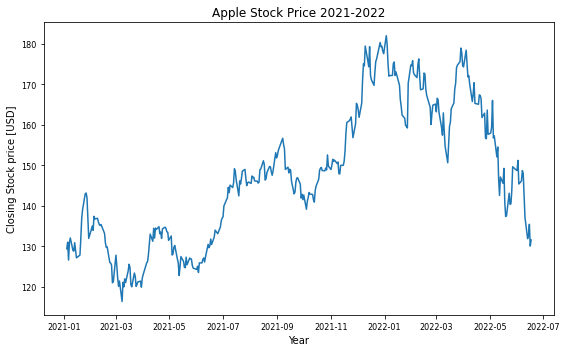

In [554]:
plt.figure(figsize=(8, 5))
plt.plot(df['Close'])
plt.title('Apple Stock Price 2021-2022');
plt.ylabel('Closing Stock price [USD]');
plt.xlabel('Year');
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
# plt.savefig('Observed_Apple_Stock_Price.png', dpi=600)
plt.show()

In [555]:
df = df.dropna()

# AD Fuller Test 

In [556]:
def adfuller_test(sales):
    result = adfuller(sales)
    print(result)
    labels = ['ADF Test Statistic','p-value']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, Hence REJECT H_0. The series is stationary.')
    else:
        print('Weak evidence against null hypothesis, Hence ACCEPT H_0. The series is not stationary.')

In [557]:
adfuller_test(df['Close'])

(-1.5861033384111254, 0.4905704173573728, 0, 367, {'1%': -3.448294490928673, '5%': -2.869447722240253, '10%': -2.570982681065269}, 1692.2842709645672)
ADF Test Statistic: -1.5861033384111254
p-value: 0.4905704173573728
Weak evidence against null hypothesis, Hence ACCEPT H_0. The series is not stationary.


In [558]:
# Save dataset
data = df['Close'].to_numpy()
print(type(data))

<class 'numpy.ndarray'>


In [559]:
# Standardize the data
close_var = np.var(df['Close'])
close_mean = np.mean(df['Close'])
# df['Close'] = (df['Close'] - close_mean) / close_var

In [560]:
# Natural log transformation to reduce skewness
nat_log_data = np.log(df['Close'])
# df['Close'] = nat_log_data

# Estimate the optimal lambda parameter for the Box-Cox transformation
lam, _ = boxcox(df['Close'])

# Apply the Box-Cox transformation to the data
df['Close'] = (np.power(df['Close'], lam) - 1) / lam

In [561]:
df1 = df
# shift = df.shift(1)
# df1=df-shift

In [562]:
df1 = df1.dropna()

In [563]:
adfuller_test(df1['Close'])

(-1.5455583063390435, 0.5108661107439191, 8, 359, {'1%': -3.4486972813047574, '5%': -2.8696246923288418, '10%': -2.571077032068342}, 7165.079029659562)
ADF Test Statistic: -1.5455583063390435
p-value: 0.5108661107439191
Weak evidence against null hypothesis, Hence ACCEPT H_0. The series is not stationary.


**The given Time Series is Stationary because:**

* ADF Statistics Value is Negative

* P-Value is Less than 0.05

Therefeore, this satisfies the Alternate Hypothesis of ADF Test-No Unit Root Exists, Time Series is Stationary

In [564]:
# Differentiate the data
diff = df1['Close'].diff().dropna()
diff2 = df1['Close'].diff().diff().dropna()
diff3 = df1['Close'].diff().diff().diff().dropna()
diff4 = df1['Close'].diff().diff().diff().diff().dropna()
diff5 = df1['Close'].diff().diff().diff().diff().diff().dropna()
diff6 = df1['Close'].diff().diff().diff().diff().diff().diff().dropna()
diff7 = df1['Close'].diff().diff().diff().diff().diff().diff().diff().dropna()
diff8 = df1['Close'].diff().diff().diff().diff().diff().diff().diff().diff().dropna()
diff9 = df1['Close'].diff().diff().diff().diff().diff().diff().diff().diff().diff().dropna()

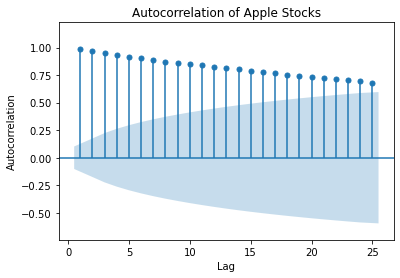

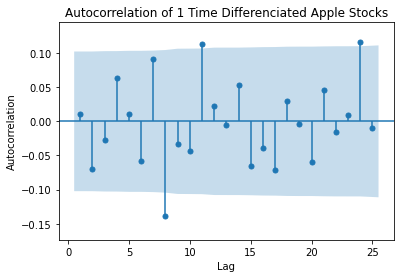

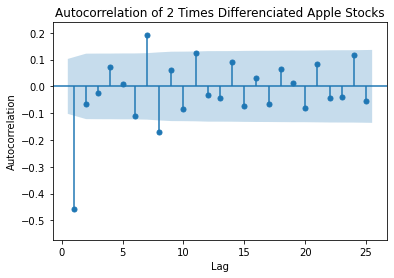

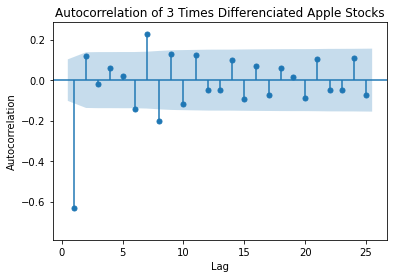

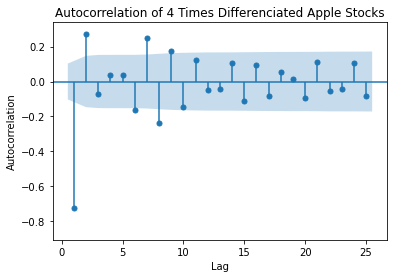

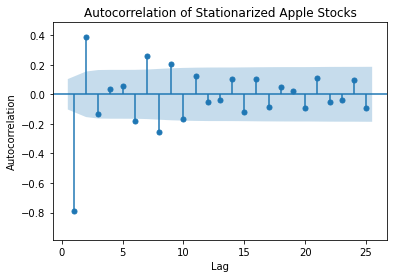

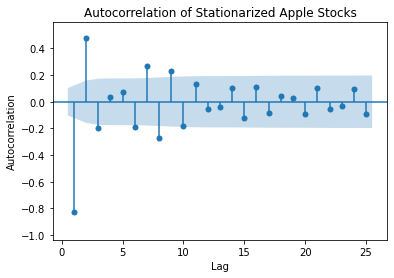

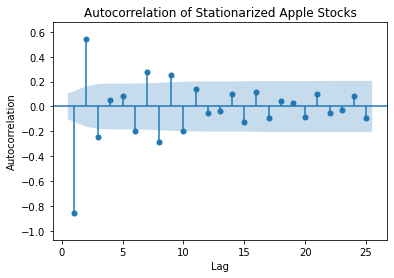

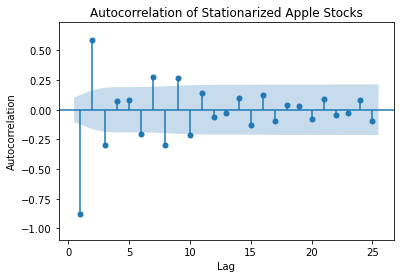

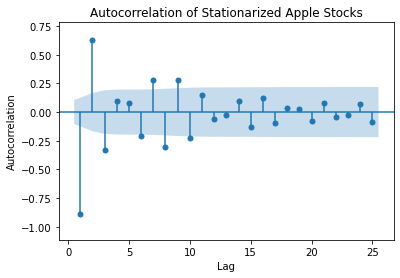

In [565]:
plot_acf(df1['Close'], alpha=0.05, lags=25, title='Autocorrelation of Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation', dpi=600)

plot_acf(diff, alpha=0.05, lags=25, title='Autocorrelation of 1 Time Differenciated Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation_diff1', dpi=600)

plot_acf(diff2, alpha=0.05, lags=25, title='Autocorrelation of 2 Times Differenciated Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation_diff2', dpi=600)

plot_acf(diff3, alpha=0.05, lags=25, title='Autocorrelation of 3 Times Differenciated Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation_diff3', dpi=600)

plot_acf(diff4, alpha=0.05, lags=25, title='Autocorrelation of 4 Times Differenciated Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation_diff4', dpi=600)

plot_acf(diff5, alpha=0.05, lags=25, title='Autocorrelation of Stationarized Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation', dpi=600)

plot_acf(diff6, alpha=0.05, lags=25, title='Autocorrelation of Stationarized Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation', dpi=600)

plot_acf(diff7, alpha=0.05, lags=25, title='Autocorrelation of Stationarized Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation', dpi=600)

plot_acf(diff8, alpha=0.05, lags=25, title='Autocorrelation of Stationarized Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation', dpi=600)

plot_acf(diff9, alpha=0.05, lags=25, title='Autocorrelation of Stationarized Apple Stocks', zero=False, auto_ylims=True);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Autocorrelation', dpi=600)


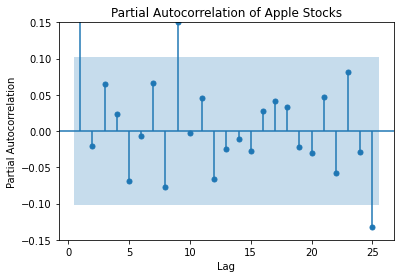

In [566]:
plot_pacf(df1['Close'], alpha=0.05, lags=25, title='Partial Autocorrelation of Apple Stocks', zero=False, auto_ylims=True);
plt.ylim([-0.15, 0.15]);
plt.ylabel('Partial Autocorrelation');
plt.xlabel('Lag');
# plt.savefig('Partial_Autocorrelation', dpi=600)

# Function to get the most optimum p,d,q values for our Model

In [567]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

**Creation of chronologic training, validation, and testing sets**

In [568]:
l = len(df1['Close'])

train_size = int(l * 0.88)
val_size = int(l * 0.1)
test_size = l - train_size - val_size

train_set = df1.iloc[: train_size]
val_set = df1.iloc[train_size : train_size + val_size]
test_set = df1.iloc[train_size + val_size :]

**Training**

In [569]:
ps = range(0, 25, 1)
d = 1 #range(0, 8, 1)
qs = range(0, 25, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9)]

In [570]:
# result_df = optimize_ARIMA(train_set, order_list)
# result_df

In [571]:
# best_model = SARIMAX(train_set, seasonal_order=(6,1,4,30), simple_differencing=False) # was (6,1,4)
# res = best_model.fit(disp=False)
# print(res.summary())

ARIMA_model = ARIMA(train_set, order=(12,1,6))
ARIMA_fit = ARIMA_model.fit()
print(ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  323
Model:                ARIMA(12, 1, 6)   Log Likelihood               -3235.491
Date:                Mon, 08 May 2023   AIC                           6508.981
Time:                        15:42:28   BIC                           6580.698
Sample:                             0   HQIC                          6537.613
                                - 323                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2558      0.124     -2.060      0.039      -0.499      -0.012
ar.L2         -0.1044      0.106     -0.982      0.326      -0.313       0.104
ar.L3         -0.2693      0.122     -2.215      0.0

**Predictions**

In [572]:
# Predictions
Y_train_pred = ARIMA_fit.predict(start=0, end=train_size-1).to_numpy()
Y_train_pred = Y_train_pred[5:]
Y_val_pred = ARIMA_fit.predict(start=train_size, end=train_size + val_size-1).to_numpy()
Y_test_pred = ARIMA_fit.predict(start=train_size + val_size, end=train_size + val_size + test_size-1).to_numpy()

# Transform back standardized data
# Inverse Box-Cox transformation
lam_train = lam[5:len(Y_train_pred)+5]
lam_val = lam[len(Y_train_pred)+5:len(Y_val_pred)+len(Y_train_pred)+5]
lam_test = lam[len(Y_val_pred)+len(Y_train_pred)+5:]

df1['Close'] = np.exp(np.log(1 + lam * df1['Close']) / lam)

print(np.shape(train_set), np.shape(lam_train))

Y_train_pred =  np.exp(np.log(1 + lam_train * Y_train_pred) / lam_train)
Y_val_pred =  np.exp(np.log(1 + lam_val * Y_val_pred) / lam_val)
Y_test_pred =  np.exp(np.log(1 + lam_test * Y_test_pred) / lam_test)

train_set = np.exp(np.log(1 + lam_train * train_set.to_numpy()) / lam_train)
val_set = np.exp(np.log(1 + lam_val * val_set.to_numpy()) / lam_val)
test_set = np.exp(np.log(1 + lam_test * test_set.to_numpy()) / lam_test)


# Inverse standardization
# df1['Close'] = df1['Close'] * close_var + close_mean

# Y_train_pred = Y_train_pred * close_var + close_mean
# Y_val_pred = Y_val_pred * close_var + close_mean
# Y_test_pred = Y_test_pred * close_var + close_mean

# train_set = train_set * close_var + close_mean
# val_set = val_set * close_var + close_mean
# test_set = test_set * close_var + close_mean

# Time arrays
train_period = date[5 : train_size]
val_period = date[train_size : train_size+val_size]
test_period = date[train_size+val_size :]
period = np.concatenate((train_period, val_period, test_period))

# Create new dataframe with predicted data
train = pd.DataFrame({'Date' : train_period, 'Close' : Y_train_pred})
train['Date']=pd.to_datetime(train['Date'])
train.set_index('Date', inplace=True)

val = pd.DataFrame({'Date' : val_period, 'Close' : Y_val_pred})
val['Date']=pd.to_datetime(val['Date'])
val.set_index('Date', inplace=True)

test = pd.DataFrame({'Date' : test_period, 'Close' : Y_test_pred})
test['Date']=pd.to_datetime(test['Date'])
test.set_index('Date', inplace=True)

print(len(data), len(period))
print(type(data))

data = data[5:]
data = pd.DataFrame({'Date' : period, 'Close' : data})
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print(data['Close'])

(323, 1) (318,)
368 363
<class 'numpy.ndarray'>
Date
2021-01-11    128.979996
2021-01-12    128.800003
2021-01-13    130.889999
2021-01-14    128.910004
2021-01-15    127.139999
                 ...    
2022-06-13    131.880005
2022-06-14    132.759995
2022-06-15    135.429993
2022-06-16    130.059998
2022-06-17    131.559998
Name: Close, Length: 363, dtype: float64


**Plot results**

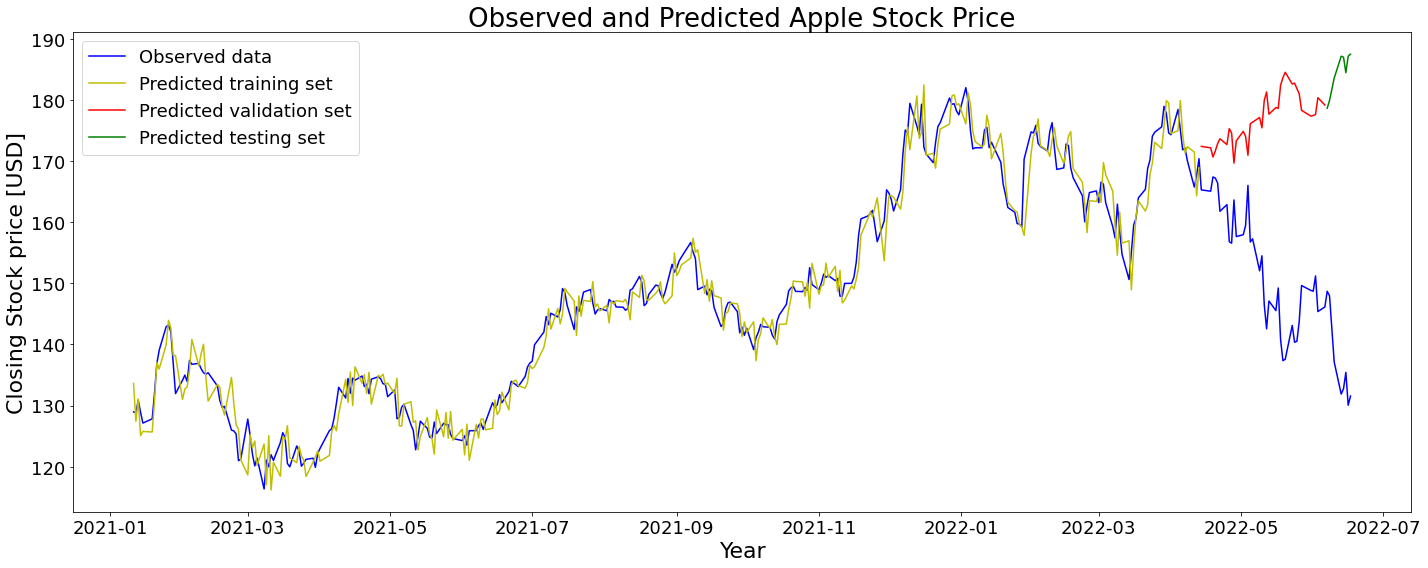

In [575]:
plt.rcParams['figure.figsize'] = (20,8)
plt.plot(data['Close'], color="b", label='Observed data') # df2['Close'][5:]
plt.plot(train['Close'], color = "y", label='Predicted training set')
plt.plot(val['Close'], color = "r", label='Predicted validation set')
plt.plot(test['Close'], color = "g", label='Predicted testing set')
plt.title("Observed and Predicted Apple Stock Price", size = 26)
plt.ylabel('Closing Stock price [USD]', size=22);
plt.xlabel('Year', size=22);
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
# plt.xlim(0, 305)
# plt.ylim(35, 190)
plt.legend(fontsize='18')
plt.tight_layout()
plt.savefig('Observed_Predicted_Apple_Stock_Price.png', dpi=600)
plt.show()

**Compute model performance**

In [574]:
# Variance
var_train = np.var(train_set)
var_train_pred = np.var(train['Close'])
var_val = np.var(val_set)
var_val_pred = np.var(val['Close'])
var_test = np.var(test_set)
var_test_pred = np.var(test['Close'])

print(f'Var train: {var_train}')
print(f'Var train pred: {var_train_pred}')
print(f'Var val: {var_val}')
print(f'Var val pred: {var_val_pred}')
print(f'Var test: {var_test}')
print(f'Var test pred: {var_test_pred}')

# Mean
mean_train = np.mean(train_set)
mean_train_pred = np.mean(train['Close'])
mean_val = np.mean(val_set)
mean_val_pred = np.mean(val['Close'])
mean_test = np.mean(test_set)
mean_test_pred = np.mean(test['Close'])

print(f'Mean train: {mean_train}')
print(f'Mean train pred: {mean_train_pred}')
print(f'Mean val: {mean_val}')
print(f'Mean val pred: {mean_val_pred}')
print(f'Mean test: {mean_test}')
print(f'Mean test pred: {mean_test_pred}')



Var train: 632.7268363976324
Var train pred: 310.4445338513842
Var val: 169.37633130614114
Var val pred: 15.984348400761275
Var test: 93.27240323147196
Var test pred: 10.197139285854998
Mean train: 148.2469105654529
Mean train pred: 147.18500665558477
Mean val: 153.09215093559806
Mean val pred: 176.92237840917514
Mean test: 137.77398937045623
Mean test pred: 184.1293133395019


ValueError: y_true and y_pred have different number of output (318!=1)